In [2]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets
import math
import numpy as np
import sys

In [34]:
### set up sqlite connection with financial.db

conn = sqlite3.connect('financial.db')
c = conn.cursor()

### alter dataframe options to present floats with 2 decimal points
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('bmh')
pd.set_option('display.max_rows', 500)

In [4]:
### Reading in district table from financial.db and converting to a dataframe
district = pd.read_sql_query("SELECT * FROM district;", conn,
                             index_col = "district_id")


## District Statistics Based on % Change in Unemployment and Crimes

In [6]:
districtAgg = pd.read_sql_query("""SELECT A3 AS Region, A2 AS District, A4 AS Population, A12 AS 'Unemployment 95', 
                                   A13 AS 'Unemployment 96', AVG(-((A12-A13)/A12) * 100) AS '% Change Unemployment', 
                                   A15 AS 'Crimes 95', A16 AS 'Crimes 96', 
                                  -((A15 - CAST(A16 AS FLOAT)) / A15) * 100 AS '% Change Crimes' 
                                   FROM district GROUP BY A2 ORDER BY A3;""", conn)

districtAgg

,Region,District,Population,Unemployment 95,Unemployment 96,% Change Unemployment,Crimes 95,Crimes 96,% Change Crimes
0,Prague,Hl.m. Praha,1204953,0.20,0.43,115.00,85677.00,99107,15.68
1,central Bohemia,Benesov,88884,1.60,1.85,15.62,2159.00,2674,23.85
2,central Bohemia,Beroun,75232,1.90,2.21,16.32,2824.00,2813,-0.39
3,central Bohemia,Kladno,149893,4.60,5.05,9.78,5244.00,5892,12.36
4,central Bohemia,Kolin,95616,3.80,4.43,16.58,2616.00,3040,16.21
5,central Bohemia,Kutna Hora,77963,2.90,4.02,38.62,2640.00,3120,18.18
6,central Bohemia,Melnik,94725,2.20,2.87,30.45,4289.00,4846,12.99
7,central Bohemia,Mlada Boleslav,112065,1.20,1.44,20.00,5179.00,4987,-3.71
8,central Bohemia,Nymburk,81344,3.30,3.97,20.30,2987.00,2487,-16.74
9,central Bohemia,Praha - vychod,92084,0.50,0.54,8.00,3810.00,4316,13.28


## Median Yearly Balance By District

In [56]:
transBalanceByYear = pd.read_sql_query("""SELECT strftime('%Y', t.Date) as Year,
                                           t.account_id,
                                           a.district_id,
                                           COUNT(t.trans_id) AS 'No. of Transactions',
                                           AVG(t.balance) AS 'Average Balance' 
                                           FROM trans t JOIN account a
                                           ON t.account_id = a.account_id
                                           GROUP BY strftime('%Y', t.Date), t.account_id""", conn)

transBalanceByYear

,Year,account_id,district_id,No. of Transactions,Average Balance
0,1993,2,1,54,32590.76
1,1993,9,70,48,21276.04
2,1993,15,70,10,32806.70
3,1993,18,43,7,17385.71
4,1993,23,30,29,44926.03
...,...,...,...,...,...
17541,1998,11333,8,71,59156.55
17542,1998,11349,1,88,38972.00
17543,1998,11359,61,95,48043.42
17544,1998,11362,67,117,34380.13


In [57]:

# Dropping the year 1993 because the number of accounts and transactions are minimal and do not stabilize until
# the following year
transBalanceByYear = transBalanceByYear.drop(transBalanceByYear[transBalanceByYear['Year'] <'1994'].index)


In [59]:
yearlyBalanceByDistrict2 = transBalanceByYear.groupby(["district_id", "Year"],as_index = False ).agg({'Average Balance': ['median', 'mean'], 'No. of Transactions': ['sum'], 'account_id': ['count']})


In [60]:
yearlyBalanceByDistrict2

district_id  Year Average Balance          No. of Transactions account_id
                               median     mean                 sum      count
0             1  1994        30273.43 33249.55               11983        205
1             1  1995        30956.69 33466.75               17172        279
2             1  1996        31815.55 33482.83               24218        438
3             1  1997        35682.56 37233.07               35490        554
4             1  1998        37406.20 39597.14               40178        554
5             2  1994        25427.85 29187.10                 774         15
6             2  1995        30188.95 33617.24                1332         19
7             2  1996        31960.96 34430.62                1940         36
8             2  1997        35900.50 37901.97                3023         42
9             2  1998        36161.10 39345.16                3218         42
10            3  1994        26220.55 28689.38                 466         12
11            3  1995        30864.75 33007.22                1013         19
12            3  1996        26587.88 30764.28                1860         42
13            3  1997        30851.30 33440.55                3214         50
14            3  1998        30627.39 34709.39                3522         50
15            4  1994        26550.48 30521.72                 995         17
16            4  1995        25614.71 30438.82                1423         24
17            4  1996        25187.08 31251.51                2175         37
18            4  1997        28510.74 33545.94                2906         48
19            4  1998        35179.75 36628.96                3309         48
20            5  1994        34369.80 33950.10                1307         24
21            5  1995        33935.78 36277.21                1923         30
22            5  1996        36208.68 37921.52                2794         52
23            5  1997        37518.65 38884.66                4126         65
24            5  1998        35659.42 39361.73                4725         65
25            6  1994        28315.43 35300.03                1125         16
26            6  1995        25233.95 30466.69                1291         20
27            6  1996        31387.60 31640.63                1879         40
28            6  1997        37810.39 37184.85                3150         48
29            6  1998        34198.15 38969.85                3718         48
30            7  1994        32684.67 35404.58                1102         18
31            7  1995        30220.98 32047.46                1345         24
32            7  1996        32083.37 33837.66                1919         34
33            7  1997        28169.50 34959.15                2707         44
34            7  1998        32567.44 39131.01                3093         44
35            8  1994        28680.67 34197.62                 992         19
36            8  1995        30453.79 32264.76                1659         29
37            8  1996        31346.64 32034.74                2482         47
38            8  1997        35058.19 35038.47                3584         56
39            8  1998        36362.99 38303.45                3882         56
40            9  1994        31397.99 31427.95                 729         12
41            9  1995        35080.19 38948.09                 977         15
42            9  1996        38514.77 40432.35                1734         33
43            9  1997        35194.70 39319.92                2960         46
44            9  1998        44482.35 45626.23                3695         46
45           10  1994        27365.53 31535.51                1419         24
46           10  1995        27899.63 29796.58                1780         27
47           10  1996        26496.28 31249.69                2278         41
48           10  1997        30800.05 34353.58                3136         48
49           10  1998     

In [62]:
yearlyBalanceMedian = transBalanceByYear.groupby(["Year", "district_id"],as_index = False )['Average Balance'].median()


In [63]:
yearlyBalanceMedian.pivot(index='Year', columns='district_id', values='Average Balance')

district_id,1,2,3,4,5,6,7,8,9,10,...,68,69,70,71,72,73,74,75,76,77
Year,,,,,,,,,,,,,,,,,,,,,
1994,30273.43,25427.85,26220.55,26550.48,34369.80,28315.43,32684.67,28680.67,31397.99,27365.53,...,32072.70,36096.69,29914.94,22264.09,29661.11,29070.63,32711.09,34795.48,26911.91,27715.10
1995,30956.69,30188.95,30864.75,25614.71,33935.78,25233.95,30220.98,30453.79,35080.19,27899.63,...,31039.43,29762.19,29215.51,33659.85,34847.84,28987.83,32954.32,33922.33,23290.88,28452.63
1996,31815.55,31960.96,26587.88,25187.08,36208.68,31387.60,32083.37,31346.64,38514.77,26496.28,...,35340.23,37246.80,31133.83,32808.43,33205.03,32824.59,32956.42,31512.61,29790.09,31108.95
1997,35682.56,35900.50,30851.30,28510.74,37518.65,37810.39,28169.50,35058.19,35194.70,30800.05,...,35805.40,37218.68,31160.47,34859.45,32561.86,34546.83,34965.95,30271.88,33405.96,36213.61
1998,37406.20,36161.10,30627.39,35179.75,35659.42,34198.15,32567.44,36362.99,44482.35,29866.34,...,37785.81,32652.64,34931.19,38042.65,33990.83,34165.08,36024.47,37475.44,37039.98,31911.33


## Median Monthly Balance By District

In [ ]:
transBalanceByMonth = pd.read_sql_query("""SELECT strftime('%Y-%m', t.Date) as Year_Month,
                                           t.account_id,
                                           a.district_id,
                                           COUNT(t.trans_id) AS 'No. of Transactions',
                                           AVG(t.balance) AS 'Average Balance' 
                                           FROM trans t JOIN account a
                                           ON t.account_id = a.account_id
                                           GROUP BY strftime('%Y-%m', t.Date), t.account_id""", conn)

transBalanceByMonth.head(n=70)

In [36]:
transBalanceByMonth = transBalanceByMonth.drop(transBalanceByMonth[transBalanceByMonth['Year_Month'] <'1994-01'].index)


In [37]:
transBalanceByMonth

,Year_Month,account_id,district_id,No. of Transactions,Average Balance
7364,1994-01,2,1,10,28187.90
7365,1994-01,9,70,12,22906.00
7366,1994-01,15,70,3,48789.67
7367,1994-01,18,43,3,30916.33
7368,1994-01,23,30,6,36749.33
...,...,...,...,...,...
185052,1998-12,11333,8,5,61316.80
185053,1998-12,11349,1,10,52655.90
185054,1998-12,11359,61,8,56767.12
185055,1998-12,11362,67,8,46428.00


In [47]:
monthlyBalanceByDistrict = transBalanceByMonth.groupby(["Year_Month", "district_id"],as_index = False ).agg({'Average Balance': ['median', 'mean'], 'No. of Transactions': ['sum'], 'account_id': ['count']})


In [48]:
monthlyBalanceByDistrict.head(n=500)

Year_Month district_id Average Balance          No. of Transactions  \
                                    median     mean                 sum   
0      1994-01           1        27158.83 29455.46                1128   
1      1994-01           2        24348.00 26496.10                  61   
2      1994-01           3        34713.67 35365.19                  49   
3      1994-01           4        24401.00 24013.00                  90   
4      1994-01           5        22499.25 28519.47                 107   
5      1994-01           6        29015.92 31737.44                 124   
6      1994-01           7        26467.62 26420.20                 127   
7      1994-01           8        23921.36 30254.29                  85   
8      1994-01           9        28379.16 28151.30                  83   
9      1994-01          10        22398.60 26489.03                 145   
10     1994-01          11        40432.84 36744.84                 123   
11     1994-01          12        29045.33 34193.11                  78   
12     1994-01          13        39074.33 38258.76                  76   
13     1994-01          14        21636.33 23781.05                  67   
14     1994-01          15        20641.73 26035.18                  85   
15     1994-01          16        26836.17 33265.30                  90   
16     1994-01          17        25533.83 30164.99                  67   
17     1994-01          18        32985.67 36502.53                  39   
18     1994-01          19        27500.90 29799.60                  87   
19     1994-01          20        33651.12 32655.88                  78   
20     1994-01          21        31442.58 33175.77                 128   
21     1994-01          22        28386.50 32255.87                  46   
22     1994-01          23        27274.45 29365.15                 112   
23     1994-01          24        35789.85 33558.14                 118   
24     1994-01          25        24418.50 30490.71                  37   
25     1994-01          26        20311.00 23594.87                  53   
26     1994-01          27        38388.33 34958.38                  78   
27     1994-01          28        36559.25 33162.28                  88   
28     1994-01          29        30237.56 32404.29                  76   
29     1994-01          30        26448.33 29997.60                 109   
30     1994-01          31        29188.68 32710.26                 136   
31     1994-01          32        25370.29 24433.24                  76   
32     1994-01          33        27854.27 29992.37                 116   
33     1994-01          34        17613.08 21071.68                  52   
34     1994-01          35        26017.75 29968.36                  79   
35     1994-01          36        27460.13 34808.82                  91   
36     1994-01          37        22000.00 23435.89                  66   
37     1994-01          38        22137.61 30362.22                 117   
38     1994-01          39        23092.64 25205.79                  83   
39     1994-01          40        29311.67 32984.48                  97   
40     1994-01          41        27840.33 31901.11                 106   
41     1994-01          42        24274.16 20664.10                  55   
42     1994-01          43        21638.00 23462.59                 104   
43     1994-01          44        23663.77 28936.10                 132   
44     1994-01          45        31456.71 30002.80                 109   
45     1994-01          46        25919.61 31091.82                  52   
46     1994-01          47        22746.70 23716.50                 107   
47     1994-01          48        25386.03 31397.35                 112   
48     1994-01          49        38253.00 33421.98                  54   
49     1994-01          50        33864.88 38283.22                 116   
50     1994-01          51        25190.50 30800.43                  81   
51     1994-01          52   

In [52]:
monthlyBalanceByDistrict = transBalanceByMonth.groupby(["district_id", "Year_Month"],as_index = False ).agg({'Average Balance': ['median', 'mean'], 'No. of Transactions': ['sum'], 'account_id': ['count']})


In [54]:
monthlyBalanceByDistrict2.head(n=500)

district_id Year_Month Average Balance          No. of Transactions  \
                                    median     mean                 sum   
0             1    1994-01        27158.83 29455.46                1128   
1             1    1994-02        26134.33 30059.91                 719   
2             1    1994-03        27797.00 31695.10                 810   
3             1    1994-04        28842.95 31278.27                 838   
4             1    1994-05        30107.75 32816.19                 932   
5             1    1994-06        30209.27 33642.57                1036   
6             1    1994-07        30010.20 32663.16                 990   
7             1    1994-08        31047.40 33448.49                 994   
8             1    1994-09        29505.72 33812.07                1041   
9             1    1994-10        30513.80 34365.47                1075   
10            1    1994-11        30960.67 35662.95                1102   
11            1    1994-12        31771.67 36573.26                1318   
12            1    1995-01        27244.38 29258.76                1988   
13            1    1995-02        26760.83 29536.77                1158   
14            1    1995-03        28750.75 32389.41                1218   
15            1    1995-04        30668.71 33588.15                1256   
16            1    1995-05        32449.80 34887.26                1292   
17            1    1995-06        32099.10 35084.20                1428   
18            1    1995-07        33266.83 34868.52                1363   
19            1    1995-08        31968.80 34095.07                1388   
20            1    1995-09        30764.00 33827.08                1391   
21            1    1995-10        32365.89 34940.46                1463   
22            1    1995-11        33829.80 36016.51                1505   
23            1    1995-12        34703.80 36941.53                1722   
24            1    1996-01        27817.61 31423.24                2654   
25            1    1996-02        27910.81 31167.64                1557   
26            1    1996-03        30124.20 33343.30                1647   
27            1    1996-04        31716.00 33995.79                1708   
28            1    1996-05        31888.62 34865.29                1761   
29            1    1996-06        31390.16 34174.79                1965   
30            1    1996-07        30860.67 33899.48                1920   
31            1    1996-08        31941.25 34159.72                2004   
32            1    1996-09        31508.77 34507.35                2031   
33            1    1996-10        32900.00 35146.39                2163   
34            1    1996-11        33418.98 36844.19                2198   
35            1    1996-12        35189.00 37822.85                2610   
36            1    1997-01        30501.57 32780.66                4045   
37            1    1997-02        30081.00 33285.76                2380   
38            1    1997-03        32335.71 35670.73                2550   
39            1    1997-04        34175.67 37010.05                2576   
40            1    1997-05        35178.80 37584.95                2696   
41            1    1997-06        34307.75 36703.49                2938   
42            1    1997-07        33063.25 35901.73                2810   
43            1    1997-08        35086.40 38046.36                2905   
44            1    1997-09        36685.86 38978.12                2945   
45            1    1997-10        36388.60 39520.83                3043   
46            1    1997-11        37368.33 39942.26                3028   
47            1    1997-12        37999.85 41036.02                3574   
48            1    1998-01        32111.65 35281.61                5436   
49            1    1998-02        31881.05 35109.43                2995   
50            1    1998-03        34405.73 38295.39                3167   
51            1    1998-04   

In [ ]:
monthlyBalanceByDistrict['No. of Transactions'].sum()

In [20]:
monthlyBalanceMedian = transBalanceByMonth.groupby(["Year_Month", "district_id"],as_index = False )['Average Balance'].median()


In [21]:
monthlyBalanceMedian.pivot(index='Year_Month', columns='district_id', values='Average Balance')

district_id,1,2,3,4,5,6,7,8,9,10,...,68,69,70,71,72,73,74,75,76,77
Year_Month,,,,,,,,,,,,,,,,,,,,,
1993-05,27221.00,18823.50,43605.25,11675.00,8276.75,34517.33,43957.00,7469.62,18458.33,33996.67,...,33348.00,26852.00,25330.50,16327.00,18301.00,4563.00,39382.67,22470.67,18573.50,26897.75
1993-06,30443.60,22532.67,21596.00,23869.00,11447.50,40342.00,42033.83,7242.00,24725.00,37740.20,...,40023.80,26599.33,25698.43,16524.42,20706.38,9463.00,35716.89,27248.50,24498.50,26390.65
1993-07,28343.00,19627.25,41587.17,15769.20,13783.00,31239.83,45094.19,13784.00,26869.88,34084.66,...,33000.00,28423.50,23080.00,19081.08,22198.77,15890.00,31204.75,35855.33,12444.00,40762.00
1993-08,30706.40,42577.00,29115.00,10197.33,17773.40,28390.58,32868.75,21104.33,29007.67,31029.83,...,31715.50,27028.20,25860.65,21316.33,26425.75,31745.00,33048.69,25744.00,18266.00,41144.56
1993-09,28582.43,20518.50,28880.00,20134.33,20115.00,26988.00,32042.77,26868.00,26609.90,25847.17,...,35183.50,29065.00,31078.00,24568.38,27221.10,16708.25,30367.67,28338.00,23034.00,28266.17
1993-10,30497.40,23948.50,39550.33,26116.00,20536.24,27355.56,35173.52,28584.37,26676.99,28883.14,...,36104.75,29858.17,27768.33,28012.08,27277.67,19218.33,34553.67,27774.00,23932.33,27949.40
1993-11,29750.67,26970.47,29921.00,22570.00,21294.67,30901.69,35335.83,31620.25,31418.00,23341.20,...,31708.47,33606.87,28952.70,26835.50,25882.88,23740.00,35009.63,28065.86,26572.67,28893.40
1993-12,28869.70,24436.50,27141.14,25772.00,23858.67,32045.60,28620.64,27380.50,30724.33,25444.78,...,33467.11,26233.75,30391.40,31364.67,29472.15,31661.43,35511.44,39552.33,25040.67,30460.20
1994-01,27158.83,24348.00,34713.67,24401.00,22499.25,29015.92,26467.62,23921.36,28379.16,22398.60,...,28908.25,31283.77,26848.83,24155.75,28349.14,28262.00,28974.93,31936.79,22336.04,26343.92


sum    1054159
dtype: int64

In [28]:
regionBalance = pd.read_sql_query("""SELECT strftime('%Y-%m', t.Date) as 'Year_Month', 
                                    AVG(t.balance) FILTER (WHERE d.A3 = 'Prague') AS Prague, 
                                    AVG(t.balance) FILTER (WHERE d.A3 = 'central Bohemia') AS 'Central Bohemia', 
                                    AVG(t.balance) FILTER (WHERE d.A3 = 'east Bohemia') AS 'East Bohemia', 
                                    AVG(t.balance) FILTER (WHERE d.A3 = 'north Bohemia') AS 'North Bohemia', 
                                    AVG(t.balance) FILTER (WHERE d.A3 = 'south Bohemia') AS 'South Bohemia', 
                                    AVG(t.balance) FILTER (WHERE d.A3 = 'west Bohemia') AS 'West Bohemia', 
                                    AVG(t.balance) FILTER (WHERE d.A3 = 'north Moravia') AS 'North Moravia', 
                                    AVG(t.balance) FILTER (WHERE d.A3 = 'south Moravia') AS 'South Moravia' 
                                    FROM district d JOIN account a JOIN trans t 
                                    ON d.district_id = a.district_id AND a.account_id = t.account_id 
                                    GROUP BY strftime('%Y-%m', t.Date)""", conn)

regionBalance = regionBalance.drop(regionBalance.index[0:5])


regionBalance

,Year_Month,Prague,Central Bohemia,East Bohemia,North Bohemia,South Bohemia,West Bohemia,North Moravia,South Moravia
5,1993-06,36496.71,38202.28,36011.50,37197.75,36380.17,35860.80,39150.38,37379.01
6,1993-07,36922.60,41701.85,34244.12,29752.45,40388.40,35342.64,37812.47,38190.30
7,1993-08,36671.83,36396.42,35074.71,31703.28,40724.33,33751.80,39035.63,37308.56
8,1993-09,35815.03,35755.01,35942.38,32520.01,38000.56,34395.26,37997.42,36631.18
9,1993-10,40031.08,38342.18,35603.54,34399.31,38257.33,35748.94,36857.71,38672.71
10,1993-11,35867.03,38500.82,37028.20,33956.12,37085.51,35689.97,37672.06,36767.80
11,1993-12,36792.84,37507.51,39137.87,37319.53,39263.26,36665.33,40197.00,39439.94
12,1994-01,31457.75,31180.71,31183.48,30196.31,31363.23,31388.45,31522.96,32090.37
13,1994-02,33514.16,32588.65,30783.20,34051.08,33164.02,33844.52,33739.47,31636.24
14,1994-03,34933.86,35086.47,36182.87,36024.19,34367.54,36333.84,36418.03,34195.83


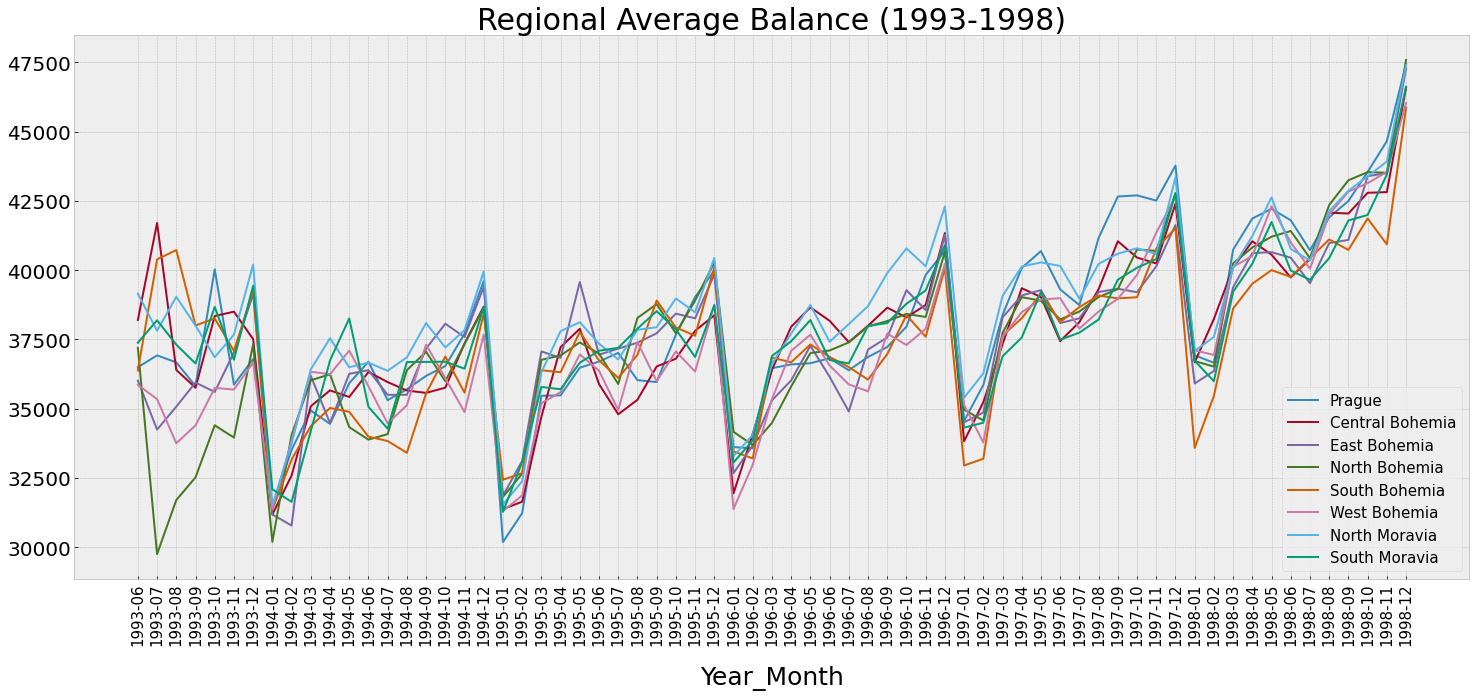

In [29]:
fig = plt.figure(figsize = (25, 10))
ax = plt.axes()

ax.plot(regionBalance['Year_Month'], regionBalance['Prague'], label='Prague')
ax.plot(regionBalance['Year_Month'], regionBalance['Central Bohemia'], label='Central Bohemia')
ax.plot(regionBalance['Year_Month'], regionBalance['East Bohemia'], label='East Bohemia')
ax.plot(regionBalance['Year_Month'], regionBalance['North Bohemia'], label='North Bohemia')
ax.plot(regionBalance['Year_Month'], regionBalance['South Bohemia'], label='South Bohemia')
ax.plot(regionBalance['Year_Month'], regionBalance['West Bohemia'], label='West Bohemia')
ax.plot(regionBalance['Year_Month'], regionBalance['North Moravia'], label='North Moravia')
ax.plot(regionBalance['Year_Month'], regionBalance['South Moravia'], label='South Moravia')
ax.tick_params(axis='x', labelsize=15, rotation=90 )
#plt.xticks(fontsize=13 ,rotation=90)
ax.tick_params(axis='y',labelsize =20)
ax.set_xlabel("Year_Month", fontsize = 25, labelpad = 20)
#ax.set_ylabel("Number of Transactions", fontsize = 25, labelpad = 20)
plt.title("Regional Average Balance (1993-1998)", fontsize = 30)
ax.legend(loc='lower right', fontsize=15)

In [41]:
accountsPerDistrict = pd.read_sql_query("SELECT district_id, COUNT(account_id) AS Accounts FROM Account GROUP BY district_id", conn)
accountsPerDistrict

,district_id,Accounts
0,1,554
1,2,42
2,3,50
3,4,48
4,5,65
5,6,48
6,7,44
7,8,56
8,9,46
9,10,48


In [42]:
accountsPerRegion = pd.read_sql_query("SELECT d.A3 AS Region, COUNT(a.account_id) AS Account FROM Account a JOIN District d ON a.district_id = d.district_id GROUP BY d.A3", conn) 

In [43]:
accountsPerRegion

,Region,Account
0,Prague,554
1,central Bohemia,574
2,east Bohemia,544
3,north Bohemia,457
4,north Moravia,793
5,south Bohemia,370
6,south Moravia,778
7,west Bohemia,430
